In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import tensorflow as tf
from tqdm.keras import TqdmCallback

sns.set_theme()

try: # are we in Colab?
    import google.colab
    COMPUTE_ENV = 'colab'
    print('Running in Colab.')
    #google.colab.drive.mount('/content/gdrive')
    #os.chdir('/content/gdrive/My Drive/projects/xxx')
    !git clone https://github.com/FriedChips/dl_basics.git
    sys.path.insert(0,'/content/dl_basics')
except: # if not...
    if "kaggle" in os.environ["PWD"]: # are we in Kaggle?
        COMPUTE_ENV = 'kaggle'
        print('Running in Kaggle.')
    else: # we're local
        COMPUTE_ENV = os.uname()[1]
        print(f"Running locally on {COMPUTE_ENV}.")
        sys.path.insert(0,'./../')
        OUTPUT_DIR = "../output/"

for gpu in tf.config.list_physical_devices("GPU"):
    print(f"Found GPU: {tf.config.experimental.get_device_details(gpu)['device_name']}.")

Running locally on beta.


In [2]:
from data_gen.synth_sequences import SynthMathData
from models.rnn import build_model_gru_01

In [7]:
P = {
    "batch_size" : 32,
    "seq_len" : 32,
    "operation" : "add",
    "distribution" : "normal",
}

data_gen = SynthMathData(P["batch_size"], P["seq_len"], P["operation"], P["distribution"], seed=42)
x, y = data_gen.__getitem__(1)
print(x.shape, x.dtype, y.shape, y.dtype)

(32, 32, 2) float32 (32,) float32


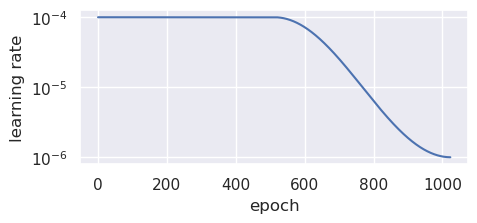

In [35]:
class Schedule_ExpCos_Segments:
    

    def __init__(self, segment_list):
        
        self.schedule = []
        
        for segment in segment_list:
            exp_start, exp_end, length = segment
            cos_ampl = (exp_start - exp_end) / 2
            cos_offset = exp_start - cos_ampl
            exp = cos_ampl * np.cos(np.pi * np.arange(length) / length) + cos_offset
            self.schedule.extend(10 ** exp)
            
        self.schedule = np.array(self.schedule)
        self.len_schedule = len(self.schedule)

        
    def scheduler(self, epoch, lr):
    
        if epoch < self.len_schedule:
            return self.schedule[epoch]
        else: # fallback if training continues longer than schedule length
            return self.schedule[-1]


    def plot_schedule(self):

        fig, ax = plt.subplots(1,1, figsize=(5,2))
        ax.plot(self.schedule);
        ax.set_yscale("log")
        ax.set_xlabel("epoch");
        ax.set_ylabel("learning rate");

    
lr_sched = Schedule_ExpCos_Segments([[-4,-4,512], [-4,-6,512]])
lr_sched.plot_schedule()

In [64]:
# init new run

model = build_model_gru_01(
    gru_units=128,
    num_outputs=1,
    input_shape=(P["seq_len"], 2),
    num_hidden_gru=2,
    use_embedding=False,
    #vocab_size=256,
    #embedding_dim=64
)

def max_abs_error(y_true, y_pred):
    return tf.reduce_max(tf.abs(y_true - y_pred), axis=-1)

model.compile(
    loss = "mse",
    optimizer = "adam",
    metrics = [max_abs_error]
)

model.summary()

P["current_epoch"] = 0
train_history = None
P["run_dir"] = model.name + datetime.datetime.now().strftime('-%y%m%d-%H%M%S')

Model: "gru_01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 2)]           0         
                                                                 
 gru_0 (GRU)                 (None, 32, 128)           50688     
                                                                 
 gru_1 (GRU)                 (None, 32, 128)           99072     
                                                                 
 gru_final (GRU)             (None, 128)               99072     
                                                                 
 linear_final (Dense)        (None, 1)                 129       
                                                                 
Total params: 248,961
Trainable params: 248,961
Non-trainable params: 0
_________________________________________________________________


In [30]:
def save_run_state():

    dest_dir = os.path.join(OUTPUT_DIR, P["run_dir"])
    os.makedirs(dest_dir, exist_ok=True)
    pd.DataFrame([P]).to_csv(os.path.join(dest_dir, "P.csv"), index=False)
    if train_history is not None:
        train_history.to_csv(os.path.join(dest_dir, "train_history.csv"), index=True)
    model_filename = os.path.join(dest_dir, f"model-e{P['current_epoch']:06d}.hdf5")
    model.save(model_filename)

In [63]:
save_run_state()

In [65]:
NUM_EPOCHS = 4
lr_sched = Schedule_ExpCos_Segments([[-3,-3, NUM_EPOCHS]])


history = model.fit(
    data_gen,
    initial_epoch = P["current_epoch"],
    epochs = P["current_epoch"] + NUM_EPOCHS,
    callbacks=[
        TqdmCallback(verbose=0),
        tf.keras.callbacks.LearningRateScheduler(lr_sched.scheduler),

    ],        
    verbose=0)

P["current_epoch"] += NUM_EPOCHS

train_history = pd.concat([train_history, pd.DataFrame(history.history)], ignore_index=True)
train_history["epoch"] = train_history.index + 1
train_history = train_history.set_index("epoch")

0epoch [00:00, ?epoch/s]

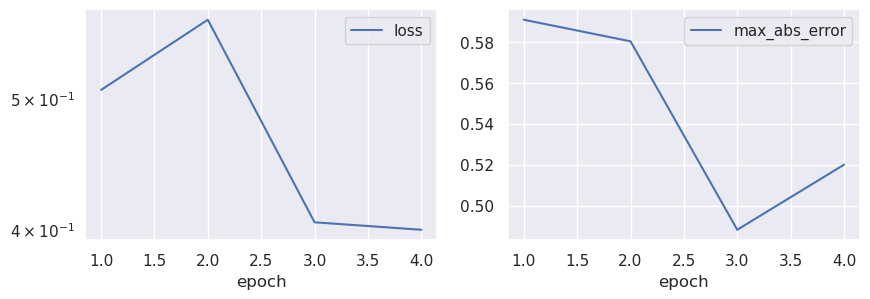

In [66]:
fig, axs = plt.subplots(1,2, figsize=(10,3))

sns.lineplot(data=train_history[["loss"]], ax=axs[0], dashes=False);
axs[0].set_yscale("log")

sns.lineplot(data=train_history[["max_abs_error"]], ax=axs[1], dashes=False);